# Analysis of a simple MAVG Strategy

In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import datetime
import sys

# Get Apple data
aapl = pdr.get_data_yahoo('AAPL', 
                          start=datetime.datetime(2006, 10, 1), 
                          end=datetime.datetime(2012, 1, 1))

## Create strategy

# Initialize the short and long windows
short_window = 40
long_window = 100
if (short_window >= long_window):
    print("Your time windows don't make sense")
    sys.exit()

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=aapl.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = aapl['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = aapl['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals: 1 if short_mavg > long_mavg, 0 o/w
signals['signal'] = np.where(signals['short_mavg'] > signals['long_mavg'], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Showing when to buy/sell the stock according to our strategy
for i in range(1,len(aapl.index)):
    if signals['positions'][i] != 0:
        print(signals.iloc[[i],[3]])


            positions
Date                 
2006-11-28        1.0
            positions
Date                 
2008-02-06       -1.0
            positions
Date                 
2008-05-06        1.0
            positions
Date                 
2008-08-11       -1.0
            positions
Date                 
2009-03-19        1.0
            positions
Date                 
2010-08-24       -1.0
            positions
Date                 
2010-09-17        1.0
            positions
Date                 
2011-05-11       -1.0
            positions
Date                 
2011-05-12        1.0
            positions
Date                 
2011-05-16       -1.0
            positions
Date                 
2011-07-22        1.0
            positions
Date                 
2011-12-27       -1.0


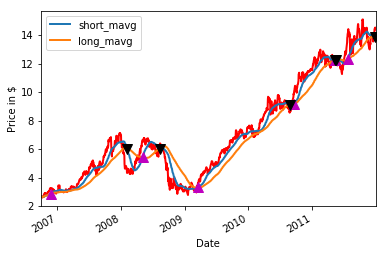

In [2]:
## Visualising positions

# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
aapl['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

In [3]:
## See returns of the strategy

# Set the initial capital
initial_capital= 100000.0

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares when the strategy says to vice versa
positions['AAPL'] = 100*signals['signal']   
  
# Initialise the portfolio with value owned   
portfolio = positions.multiply(aapl['Adj Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(aapl['Adj Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(aapl['Adj Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the last lines of `portfolio`
print(portfolio.tail())

                   AAPL     holdings           cash          total   returns
Date                                                                        
2011-12-23  1244.761562  1244.761562   99446.611285  100691.372848  0.000147
2011-12-27     0.000000     0.000000  100701.249099  100701.249099  0.000098
2011-12-28     0.000000     0.000000  100701.249099  100701.249099  0.000000
2011-12-29     0.000000     0.000000  100701.249099  100701.249099  0.000000
2011-12-30     0.000000     0.000000  100701.249099  100701.249099  0.000000


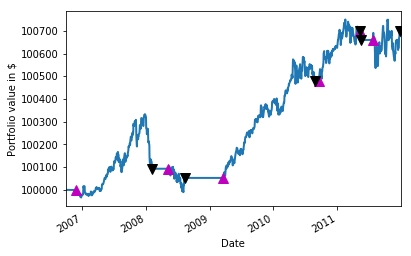

In [4]:
## Visualising the performance of the portfolio

# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

In [5]:
# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

0.7209791379023839


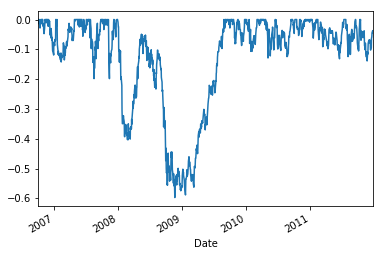

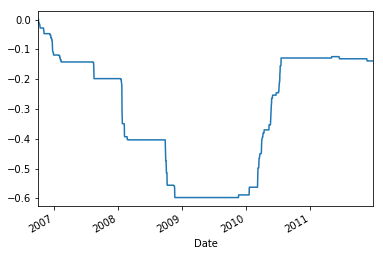

In [6]:
# Define a trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day 
rolling_max = aapl['Adj Close'].rolling(window, min_periods=1).max()
daily_drawdown = aapl['Adj Close']/rolling_max - 1.0

# Calculate the maximum daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
daily_drawdown.plot()
plt.show()

max_daily_drawdown.plot()

# Show the plot
plt.show()

In [7]:
# Get the number of days in `aapl`
days = (aapl.index[-1] - aapl.index[0]).days

# Calculate the CAGR 
cagr = ((((aapl['Adj Close'][-1]) / aapl['Adj Close'][1])) ** (365.0/days)) - 1

# Print the CAGR
print(cagr)

0.38234457063677674
